# Autoencoder on global data

# 0. Imports

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset

import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, AveragePooling2D, BatchNormalization
from keras.layers import Flatten, Dense, Lambda, Reshape
from keras.models import Model, load_model
from keras import optimizers
from keras import regularizers

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

from sklearn.model_selection import train_test_split

import gc #garbace collector
import multiprocessing as mp

import os

%load_ext tensorboard
import datetime

/home/sebastian/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sebastian/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sebastian/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sebastian/anaconda3/envs/py37/lib/pyt

# 1. Custom functions

#### Reflection Padding class

In [2]:
from keras.engine.topology import Layer
from keras.engine import InputSpec

import math
from keras import backend as K

In [3]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

#### Charbonnier loss

A General and Adaptive Robust Loss Function - Jonathan T. Barron, Google Research <br>
https://arxiv.org/pdf/1701.03077.pdf

In [4]:
def charbonnier(y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred) + 1e-10))

def charbonnier_sum(y_true, y_pred):
    return K.sum(K.sqrt(K.square(y_true - y_pred) + 1e-10), axis=-1)

#### KL loss

In [5]:
def KL_loss():
    loss  = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    loss  = K.sum(loss, axis=-1)
    loss *= -0.5
    
    return loss

#### VAE loss

In [6]:
from keras.callbacks import Callback

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [8]:
class AnnealingCallback(Callback):
    def __init__(self, weight):
        self.weight = weight
    def on_epoch_end(self, epoch, logs={}):
        new_weight = K.get_value(self.weight)
         
        if new_weight!=1: 
            if epoch+1 >= KL_start:
                print("KL_weight: " + str(new_weight))
                new_weight = sigmoid(-10 + KL_growth*(epoch+1-KL_start))
            
        if new_weight > 1 - 1e-6:
            new_weight = 1
            
        K.set_value(self.weight, new_weight)

In [9]:
def VAE_loss(y_true, y_pred):
    global weight
    
    rc_loss = charbonnier_sum(y_true, y_pred)
    #rc_loss = charbonnier(y_true, y_pred)
    #rc_loss = K.sum(K.square(y_true - y_pred), axis=-1)
    
    KL_loss  = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    KL_loss  = K.sum(KL_loss, axis=-1)
    KL_loss *= -0.5

    return K.mean(rc_loss + weight*KL_loss)

In [10]:
def perceptual_loss(y_true, y_pred):
    y_true = keras.layers.Concatenate()([y_true, y_true, y_true])
    y_pred = keras.layers.Concatenate()([y_pred, y_pred, y_pred])
    
    h1_list = lossModel(y_true)
    h2_list = lossModel(y_pred)
    
    rc_loss = 0.0
    
    for h1, h2, weight in zip(h1_list, h2_list, selected_pm_layer_weights):
        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        #rc_loss = rc_loss + weight * K.mean(K.sum(K.square(h1 - h2), axis=-1))
        rc_loss = rc_loss + weight * charbonnier_sum(h1, h2)
    return 0.5*rc_loss

In [11]:
def VAE_DFC_loss(y_true, y_pred):
    '''Total loss for the DFC VAE'''
    global weight
    
    return K.mean(perceptual_loss(y_true, y_pred) + weight*KL_loss(), axis=-1)

#### PSNR for image quality measurement

In [12]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return 10.0 / math.log(10) * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true + 1e-10), axis=-1)))

def PSNR_np(y_true, y_pred):
    max_pixel = 1.0
    return 10.0 / np.log(10) * np.log((max_pixel ** 2) / (np.mean((y_pred - y_true + 1e-10)**2)))

#### Reparametrization trick

In [13]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [14]:
def lr_schedule(epoch):
    """
    Returns a custom learning rate that decreases as epochs progress.
    """
    learning_rate = 5e-5
    
    if epoch%2 == 0:
        learning_rate = learning_rate / (1.0005*(epoch+1))

    #tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

# 2. Loading the data

In [15]:
nc = Dataset('GEBCO_2019.nc', 'r')
dim1 = int(np.array(nc.variables['lon']).shape[0])
dim2 = int(np.array(nc.variables['lat']).shape[0])
Z = np.flip(np.array(nc.variables['elevation']), axis=0) #otherwise the 'map' is upside down and mirrored

Cropped = None

#### To use only Hawaii:


nc = Dataset('tohoku_gebco_ucsb3_2000m_hawaii_bath.nc', 'r')
Cropped = True

dim1 = int(np.array(nc.variables['x']).shape[0])
dim2 = int(np.array(nc.variables['y']).shape[0])
Z = np.flip(np.array(nc.variables['z']), axis=0)


In [15]:
nc = Dataset('tohoku_2020/tohoku_2020.nc', 'r')
Cropped = True

dim1 = int(np.array(nc.variables['lon']).shape[0])
dim2 = int(np.array(nc.variables['lat']).shape[0])
Z = np.flip(np.array(nc.variables['elevation']), axis=0)

#### Other small subset

nc = Dataset('GEBCO_2019_cropped.nc', 'r')
dim1 = int(np.array(nc.variables['lon']).shape[0])
dim2 = int(np.array(nc.variables['lat']).shape[0])
Z = np.flip(np.array(nc.variables['elevation']), axis=0)

Cropped = True

In [16]:
dim1, dim2, Z.shape

(17730, 9255, (9255, 17730))

# 3. Pre-processing

#### 'Remove' altitudes > 0 by setting their values to be 0.

In [17]:
#Z[Z>0] = 0

In [18]:
Z_global_min = -10880.587890625
Z_global_max = 8613.15625

Z_local_min = np.min(Z)
Z_local_max = np.max(Z)

#### Offset values to be non-negative

In [19]:
Z_min = Z_global_min #Z_local_min
Z = Z + np.abs(Z_min)

#### Rescaling to [0, 1]

In [20]:
Z_max = Z_global_max + np.abs(Z_min) #Z_local_max + np.abs(Z_local_min)
Z_max

Z = Z / Z_max

In [21]:
np.min(Z), np.max(Z)

(-0.0036633347016275354, 0.7717136216676884)

#### Plot the map

In [22]:
#plt.matshow(Z)

#### Create 3-dimensional array containing num_images small pictures.

In [23]:
x, y = 96, 96

num_images = int(dim1*dim2 / (x*y))
num_images

17805

In [24]:
ratio_x = dim1/x
ratio_y = dim2/y

ratio_x, ratio_y

(184.6875, 96.40625)

In [25]:
cutoff_x = math.ceil(x * (ratio_x-int(ratio_x)))
cutoff_y = math.ceil(y * (ratio_y-int(ratio_y)))
    
cutoff_x, cutoff_y

(66, 39)

In [26]:
data = np.zeros([num_images, y, x])
i=0
for r in range(0, Z.shape[0]-cutoff_y, y):
    for c in range(0, Z.shape[1]-cutoff_x, x):
        data[i, :, :] = Z[r:r+y, c:c+x]
        i = i + 1

In [27]:
if Cropped==True:
    for i in range(data.shape[0]):
        data[i,:,:] = data[i,:,:].T

#### Split into train and test set

In [28]:
#def split_1(queue, data):
#    result = train_test_split(data, test_size=0.01)
#    queue.put(result)

In [29]:
#queue = mp.Queue()
#p = mp.Process(target=split_1, args=(queue, data_augmented))
#p.start()
#p.join()

#results = queue.get()

#p.close()



In [30]:
#gc.collect()

In [31]:
test_size = 0.05
X_training, X_test = train_test_split(data, test_size=test_size, random_state=7)

## Data Augmentation

Add 90-degree rotations as augmented data

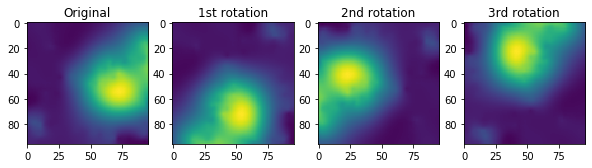

In [32]:
plt.figure(figsize=(10, 4))

plt.subplot(1,4,1)
plt.imshow(X_training[33, ...])
plt.title("Original")

plt.subplot(1,4,2)
plt.imshow(X_training[33, ...].T)
plt.title("1st rotation")

plt.subplot(1,4,3)
plt.imshow(np.flip(X_training[33, ...]))
plt.title("2nd rotation")

plt.subplot(1,4,4)
plt.imshow(np.flip(X_training[33, ...].T))
plt.title("3rd rotation")

plt.show()

In [33]:
index = int(num_images*(1-test_size))
if Cropped == True:
    X_train = np.zeros([index*4, y, x])
else:
    X_train = np.zeros([index*2, y, x])
    
X_train[0:index, :, :] = X_training

In [34]:
for j in range(index):
    X_train[index*1 + j, :, :] = X_training[j, :, :].T
    if Cropped == True:
        X_train[index*2 + j, :, :] = np.flip(X_training[j, :, :])
        X_train[index*3 + j, :, :] = np.flip(X_training[j, :, :].T)

In [35]:
X_training.shape, X_train.shape

((16914, 96, 96), (67656, 96, 96))

#### Reshaping for Keras

In [36]:
X_train = X_train.reshape(-1, y, x, 1)


In [37]:
X_test = X_test.reshape(-1, y, x, 1)

In [38]:
X_train.shape, X_test.shape

((67656, 96, 96, 1), (891, 96, 96, 1))

#### Free up some memory

In [39]:
del X_training

In [40]:
gc.collect()

8444

#### Create validation set

In [41]:
X_train, X_val = train_test_split(X_train, test_size=0.05, random_state=7)

In [42]:
gc.collect()

50

# 4. Convolutional Autoencoder

### 4.1 Network parameters

In [43]:
epochs      = 100
batch_size  = 128
kernel_down = 4
kernel_up   = 3
filters_enc = [64, 128, 128, 256]
filters_dec = filters_enc.copy()
filters_dec.reverse()

pre_latent  = 100
latent_dim  = 100

KL_start = 3
KL_growth = 1.3

### 4.2 Define Variational Autoencoder

In [44]:
#encoder model
inputs  = Input(shape = (y, x, 1), name='encoder_inputs')

a = inputs
filters = filters_enc

for i in range(3):
    a = ReflectionPadding2D(padding=(1,1))(a)
    a = Conv2D(filters[i], kernel_initializer='he_uniform', 
               kernel_size=kernel_down, #kernel_regularizer=regularizers.l1(1e-4), 
               strides=2, padding='valid')(a)
    a = BatchNormalization(axis=3)(a)
    a = keras.layers.LeakyReLU()(a)

a = ReflectionPadding2D(padding=(1,1))(a)
a = Conv2D(filters[i+1], kernel_initializer='he_uniform', 
           kernel_size=kernel_down, #kernel_regularizer=regularizers.l1(1e-4), 
           strides=2, padding='valid')(a)
a = BatchNormalization(axis=3)(a)
a = keras.layers.LeakyReLU(name='encoded')(a)

#shape retrieval for decoder part
shape = K.int_shape(a)

#a = keras.layers.GlobalAveragePooling2D()(a)

# generate latent vector Q(z|X)
a = Flatten()(a)
a = Dense(pre_latent, activation='relu', kernel_initializer='he_uniform')(a)
z_mean = Dense(latent_dim, name='z_mean')(a)
z_log_var = Dense(latent_dim, name='z_log_var')(a)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

In [45]:
#encoder.summary()

In [46]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
a = Dense(pre_latent, activation='relu', kernel_initializer='he_uniform')(latent_inputs)
a = Dense(shape[1] * shape[2] * shape[3], activation='relu', kernel_initializer='he_uniform')(a)
a = Reshape((shape[1], shape[2], shape[3]))(a)

filters = filters_dec
for i in range(3):

    a = UpSampling2D((2,2))(a)
    a = ReflectionPadding2D(padding=(1,1))(a)
    a = Conv2D(filters[i+1], kernel_size=kernel_up, #kernel_regularizer=regularizers.l2(1e-3), 
               strides=1, kernel_initializer='he_uniform', padding='valid')(a)
    a = BatchNormalization(axis=3)(a)
    a = keras.layers.LeakyReLU()(a)
    
#a = ReflectionPadding2D(padding=(1,1))(a)
#a = Conv2D(32, kernel_size=kernel_up, #kernel_regularizer=regularizers.l2(1e-3), 
#           strides=1, kernel_initializer='he_uniform', padding='valid')(a)
#a = BatchNormalization(axis=3)(a)
#a = keras.layers.LeakyReLU()(a)    

a = UpSampling2D((2,2))(a)
a = ReflectionPadding2D(padding=(1,1))(a)
out = Conv2D(filters=1, kernel_size=kernel_up, #kernel_regularizer=regularizers.l2(1e-3), 
             kernel_initializer='he_normal', activation='sigmoid',
             padding='valid', name='decoder_output')(a)

# instantiate decoder model
decoder = Model(latent_inputs, out, name='decoder')

In [47]:
#decoder.summary()

In [48]:
outputs = decoder(encoder(inputs)[2])
VAE = Model(inputs, outputs, name='VAE')
VAE_dummy = Model(inputs, outputs)
VAE.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  (None, 96, 96, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 100), (None, 100) 1863308   
_________________________________________________________________
decoder (Model)              (None, 96, 96, 1)         1459189   
Total params: 3,322,497
Trainable params: 3,320,705
Non-trainable params: 1,792
_________________________________________________________________


### 4.3 Fit Autoencoder

### Callbacks

In [49]:
!mkdir model_weights/$(date +%Y%m%d)

mkdir: cannot create directory ‘model_weights/20200513’: File exists


In [50]:
filepath='model_weights/' + datetime.datetime.now().strftime('%Y%m%d') + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
save_weights_callback = keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                                                  save_weights_only=True)

In [51]:
#!rm -rf ./logs/

log_dir='logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, write_grads=True, write_images=True)

### Fit

In [52]:
weight = K.variable(0.0)
VAE.add_loss(VAE_loss(K.flatten(inputs), K.flatten(outputs)))
#VAE.add_loss(VAE_loss(inputs, outputs))

In [53]:
VAE.compile(optimizer = optimizers.Adam(lr=1e-6, clipnorm=1))
#VAE.compile(optimizer = optimizers.Adam(decay=1e-4, clipnorm=1))

#workaround for PSNR
VAE_dummy.compile(optimizer=optimizers.Adam(), loss=[charbonnier], metrics=[PSNR])

In [54]:
#VAE.load_weights('VAE_DFC_global_100e.hdf5')
VAE.load_weights('VAE_global_100e.hdf5')

In [56]:
VAE.fit(X_train, batch_size=batch_size, epochs=epochs, verbose=1, initial_epoch=71,
        validation_data=(X_val, None), 
        callbacks=[AnnealingCallback(weight),
                   save_weights_callback,
                   #tensorboard_callback,
                   #keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-6),
                   #keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)
                  ]
       )

Train on 731025 samples, validate on 38475 samples
Epoch 72/100
731025/731025 [==============================] - 584s 799us/step - loss: 5001.4635 - val_loss: 3430.7038
KL_weight: 0.0
Epoch 73/100
731025/731025 [==============================] - 579s 793us/step - loss: 5450.3229 - val_loss: 3954.2455
Epoch 74/100
731025/731025 [==============================] - 580s 793us/step - loss: 5445.5597 - val_loss: 3819.8997
Epoch 75/100
731025/731025 [==============================] - 580s 793us/step - loss: 5445.8732 - val_loss: 3983.0493
Epoch 76/100
731025/731025 [==============================] - 579s 792us/step - loss: 5442.4553 - val_loss: 4344.3839
Epoch 77/100
731025/731025 [==============================] - 577s 789us/step - loss: 5390.8671 - val_loss: 4058.9830
Epoch 78/100
731025/731025 [==============================] - 579s 792us/step - loss: 5408.2239 - val_loss: 3825.3471
Epoch 79/100
731025/731025 [==============================] - 578s 790us/step - loss: 5354.1877 - val_loss: 

In [ ]:
# ssh -NL 1235:localhost:1235 sebastian@10.195.2.9
#tensorboard --logdir=./logs --port 1235

In [ ]:
#from tensorboard import notebook
#notebook.list()

In [62]:
#!kill 11952

/bin/sh: 1: kill: No such process



In [57]:
#VAE.save_weights('model_weights/20200510/weights_end.hdf5')
#VAE.save('VAE_Hawaii_150e.hd5')
#VAE.save_weights('VAE_DFC_cropped_100e.hd5')

In [58]:
VAE_dummy.evaluate(X_train, X_train)[1], VAE_dummy.evaluate(X_val, X_val)[1]

38475/38475 [==============================] - 14s 361us/step


(56.68273512558777, 56.64920675950673)

### 4.4 Plot training & validation losses

ValueError: x and y must have same first dimension, but have shapes (100,) and (29,)

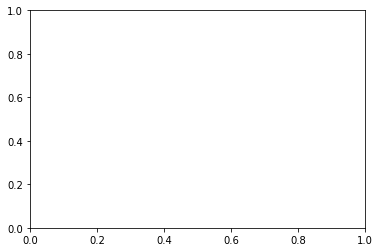

In [59]:
VAE_train = VAE.history
loss = VAE_train.history['loss']
val_loss = VAE_train.history['val_loss']

plt.figure()
plt.plot(range(epochs), loss, 'bo', label='Training loss')
plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

### 4.5 Predicted, reconstructed & latent space images

In [56]:
#VAE.load_weights('VAE_global_10e.hd5')

In [55]:
pred = VAE.predict(X_test)

encoded = Model(inputs=inputs, outputs=encoder.get_layer('encoded').output)
encoded_states = np.mean(encoded.predict(X_test), axis=3, keepdims=True)

x_encoded = encoded_states.shape[1]
y_encoded = encoded_states.shape[2]

Test Images (96x96)


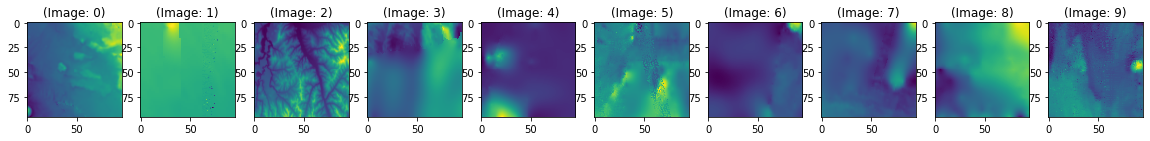

Reconstruction of Test Images (96x96)


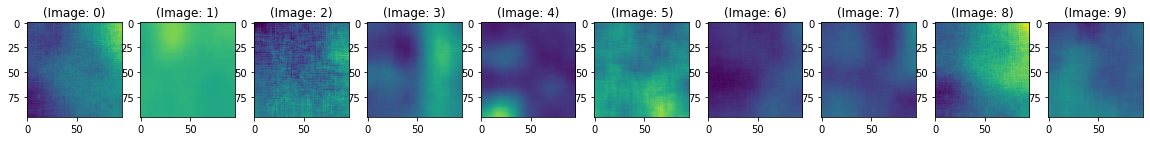

Latent Representation of Test Images (6x6)


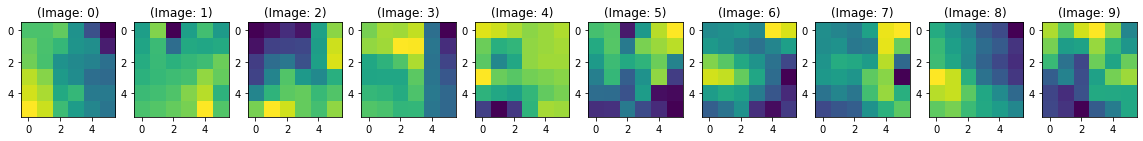

In [56]:
vmin = np.zeros(10)
vmax = np.zeros(10)

plt.figure(figsize=(20, 4))
print("Test Images (" + str(y) + "x" + str(x) + ")")
for i in range(10):
    plt.subplot(2, 10, i+1)
    vmin[i] = np.min(X_test[i, ..., 0])
    vmax[i] = np.max(X_test[i, ..., 0])
    plt.imshow(X_test[i, ..., 0], norm=plt.Normalize(vmin=vmin[i], vmax=vmax[i]))
    plt.title("(Image: " + str(i) + ")")
plt.show()

plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images (" + str(y) + "x" + str(x) + ")")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], norm=plt.Normalize(vmin=vmin[i], vmax=vmax[i]))
    plt.title("(Image: " + str(i) + ")")
plt.show()

plt.figure(figsize=(20, 4))
print("Latent Representation of Test Images (" + str(y_encoded) + "x" + str(x_encoded) + ")")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(encoded_states[i, ..., 0])#, norm=plt.Normalize())
    plt.title("(Image: " + str(i) + ")")
plt.show()

In [ ]:
%%javascript
IPython.notebook.save_notebook()

# 5. Reconstruction Errors

#### On Test set

In [57]:
error_test = np.linalg.norm(X_test - pred, axis=(1,2))
PSNR_test = [PSNR_np(X_test[i], pred[i]) for i in range(X_test.shape[0])]
np.linalg.norm(error_test), np.mean(PSNR_test)

(58.81769925259757, 48.12041930709894)

In [58]:
x1 = np.argmax(error_test)
x2 = np.argmin(PSNR_test)
error_test[x1], PSNR_test[x2]

(array([19.41833965]), 13.881182791438839)

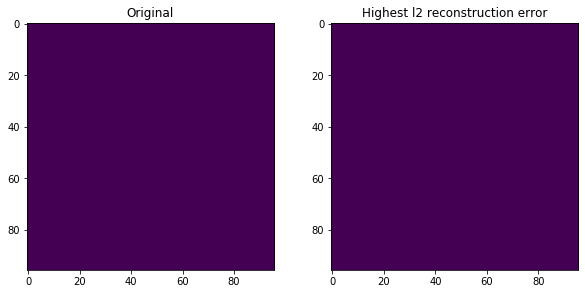

In [59]:
vmin = np.min(X_test[x1, :, :, 0])
vmax = np.max(X_test[x1, :, :, 0])

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("Original")
plt.imshow(X_test[x1, :, :, 0], norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.subplot(2,2,2)
plt.title("Highest l2 reconstruction error")
plt.imshow(pred[x1, :, :, 0], norm=plt.Normalize(vmin=vmin, vmax=vmax))

#### Total Reconstruction error

In [60]:
data_reconstructed = VAE.predict(data.reshape(-1, y, x, 1)).reshape(-1, y, x)

error_total = np.linalg.norm(data - data_reconstructed, axis=(1,2))
PSNR_total  = [PSNR_np(data[i], data_reconstructed[i]) for i in range(data.shape[0])]
np.linalg.norm(error_total), np.mean(PSNR_total)

(249.67346112422894, 48.44910401910289)

In [61]:
x3 = np.argmax(error_total)
x4 = np.argmin(PSNR_total)
error_total[x3], PSNR_total[x4]

(19.461841456749028, 13.861746050229186)

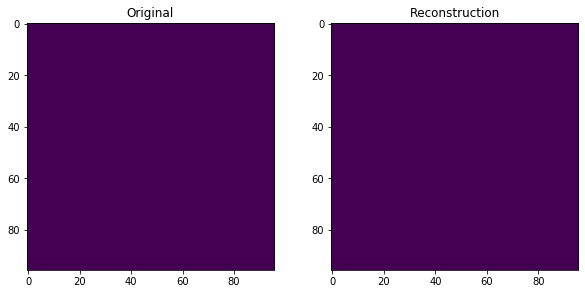

In [62]:
vmin = np.min(data[x3, :, :])
vmax = np.max(data[x3, :, :])

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("Original")
plt.imshow(data[x3, :, :], norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.subplot(2,2,2)
plt.title("Reconstruction")
plt.imshow(data_reconstructed[x3, :, :], norm=plt.Normalize(vmin=vmin, vmax=vmax))

# 6. Entire map

#### Reshape to match model input shape

In [70]:
data_encoded = data.reshape(-1, y, x, 1)

Values are already [0,1]

#### Encode entire dataset

In [ ]:
data_encoded = np.mean(encoded.predict(data_encoded), axis=3, keepdims=True)

In [ ]:
data_reconstructed.shape, data_encoded.shape

In [ ]:
gc.collect()

#### Retransform to one big matrix

In [ ]:
dim2, int(ratio_y)*y, Z.shape

In [63]:
if Cropped==True:
    #Z_reconstructed = np.zeros([int(ratio_y)*y, int(ratio_x)*x])
    Z_reconstructed = Z.copy()

    i=0
    for r in range(0, Z.shape[0]-cutoff_y, y):
        for c in range(0, Z.shape[1]-cutoff_x, x):
            Z_reconstructed[r:r+y, c:c+x] = data_reconstructed[i, ..., 0].T
            i = i + 1
            
    #Z_reconstructed[dim2-cutoff_y:, dim1-cutoff_x:] = Z[dim2-cutoff_y:, dim1-cutoff_x:]

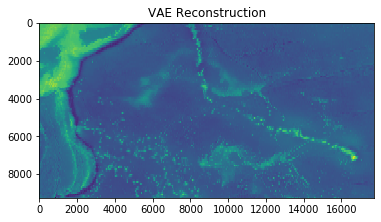

In [65]:
plt.imshow(Z_reconstructed)#, norm=plt.Normalize(vmin=np.min(Z), vmax=np.max(Z)))
plt.title("VAE Reconstruction")
plt.savefig('tohoku_2020/summary_03_VAE.pdf')

In [ ]:
Z_encoded = np.zeros([int(ratio_y)*y_encoded, int(ratio_x)*x_encoded])

i=0
for r in range(0, Z_encoded.shape[0], y_encoded):
    for c in range(0, Z_encoded.shape[1], x_encoded):
        Z_encoded[r:r+y_encoded, c:c+x_encoded] = data_encoded[i, ..., 0].T
        i = i + 1

#### Plot latent space representation

In [ ]:
if Cropped==True:
    vmin = np.min(Z)
    vmax = np.max(Z)
    
    plt.figure(figsize=(15,15))
    plt.subplot(2,2,1)
    plt.title("Original")
    plt.imshow(Z, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    plt.subplot(2,2,2)
    plt.title("Reconstructed")
    plt.imshow(Z_reconstructed)#, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    plt.subplot(2,2,3)
    plt.title("Latent")
    plt.imshow(Z_encoded, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    
    plt.tight_layout()
    #plt.subplots_adjust(hspace=-0.53)
else:
    plt.matshow(Z_encoded)

Z_reconstructed = np.zeros([int(ratio_y)*y, int(ratio_x)*x])
vmin = np.min(Z)
vmax = np.max(Z)

i=0
for r in range(0, Z_reconstructed.shape[0], y):
    for c in range(0, Z_reconstructed.shape[1], x):
        Z_reconstructed[r:r+y, c:c+x] = data_reconstructed[i, ..., 0].T
        i = i + 1

<Figure size 14400x14400 with 0 Axes>

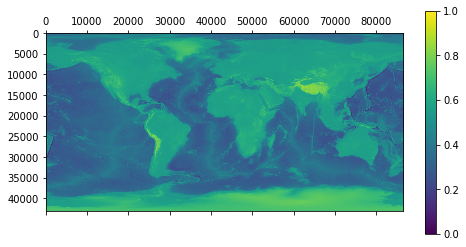

In [76]:
plt.figure(figsize=(200,200))
plt.matshow(Z, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar()

In [191]:
print('Original space: ' + str(dim2) + 'x' + str(dim1))
print('Reduced space:  ' + str(Z_encoded.shape[0]) + 'x' + str(Z_encoded.shape[1]))
print('--> reduction of ' + str(np.round((1 - Z_encoded.shape[0]*Z_encoded.shape[1]/dim1/dim2)*100, 2)) + '%')

Original space: 43200x86400
Reduced space:  2700x5400
--> reduction of 99.61%


In [192]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

# Create output netCDF file 

In [74]:
#Z_reconstructed = Z_reconstructed - np.min(Z_reconstructed)
#Z_reconstructed = Z_reconstructed / np.max(Z_reconstructed)

In [74]:
Z_reconstructed = Z.copy()

i=0
for r in range(0, Z.shape[0]-cutoff_y, y):
    for c in range(0, Z.shape[1]-cutoff_x, x):
        Z_reconstructed[r:r+y, c:c+x] = data_reconstructed[i, ..., 0].T
        i = i + 1

In [75]:
Z_reconstructed = Z_reconstructed * Z_max - np.abs(Z_min)

In [76]:
!cp tohoku_gebco_ucsb3_2000m_hawaii_bath.nc Hawaii_bath_VAE_DFC.nc

In [77]:
out = Dataset('Hawaii_bath_VAE_DFC.nc', 'r+')

In [78]:
temp  = np.flip(out.variables['z'][:], axis=0)

In [79]:
np.max(temp), np.max(Z_reconstructed)

(4011.1506, 1363.8857)

In [80]:
np.min(temp), np.min(Z_reconstructed)

(-9843.522, -8520.608)

In [91]:
#temp[temp<0] = np.mean(temp[temp<0])

In [79]:
#index = np.array(np.where(temp>=0))
#for i in range(index.shape[1]):
#    Z_reconstructed[index[0,i], index[1,i]] = temp[index[0,i], index[1,i]]

In [102]:
bathymetry_weights = np.zeros_like(Z_reconstructed)

min_bath = -200 #np.min(temp)

index = np.array(np.where((temp < 0) & (temp > min_bath)))

In [103]:
#for i in range(index.shape[1]):
#    bathymetry_weights[index[0,i], index[1,i]] = temp[index[0,i], index[1,i]] / min_bath
bathymetry_weights[(temp>=min_bath) & (temp<0)] = temp[(temp>=min_bath) & (temp<0)] / min_bath
bathymetry_weights[temp<min_bath] = 1

In [104]:
Z_reconstructed = bathymetry_weights*Z_reconstructed + (1-bathymetry_weights)*temp

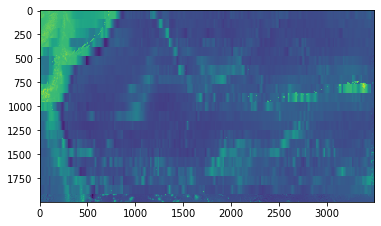

In [105]:
plt.imshow(Z_reconstructed)

In [81]:
out.variables['z'][:] = np.flip(Z_reconstructed, axis=0)

In [82]:
out.close()